# Step 4.3: Analysis: Model by prompt type and university, then major

Depends on: 
- CSV file generated in step 3 containing all results and metadata: `processed_data/umg_all_parsed_queries.csv`

Outputs: results in notebook, also files:
- PDF and EPS figures: 
  - `results/runtype_x_model_x_univcat_boxenplot.{pdf|eps}`
  - `results/ols_univ_effect_allmodels.{pdf|eps}` (not used in paper)
  - `results/runtype_x_model_x_major_boxenplot.{pdf|eps}`
  - `results/runtype_x_model_x_majortype_boxenplot.{pdf|eps}`
  - `results/ols_major_effect_allmodels.{pdf|eps}` (not used in paper)
  - `results/ols_major_effect_{model}.{pdf|eps}` (4, one for each model)
  - `results/median_pronoun_major_{prompt}_{model}.{pdf|eps}` (8, model x prompt)

In [1]:
import os
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import re
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Data input and cleaning

In [2]:
models = [ "gpt-3.5-turbo-0613", "gpt-3.5-turbo-0125", "gpt-4-turbo-2024-04-09", "gpt-4o-2024-05-13"]

In [3]:
df = pd.read_csv("processed_data/umg_all_parsed_queries.csv")
df['Univ_Category'] = df['USNWR_Category'].fillna('Online')
df.drop("USNWR_Category", axis=1, inplace=True)
df

index   custom_id               model   content  run_id  \
0       41704  task-41704  gpt-3.5-turbo-0125  $120,000   41704   
1       41705  task-41705  gpt-3.5-turbo-0125  $110,000   41705   
2       41706  task-41706  gpt-3.5-turbo-0125  $110,000   41706   
3       41707  task-41707  gpt-3.5-turbo-0125  $110,000   41707   
4       41708  task-41708  gpt-3.5-turbo-0125  $110,000   41708   
...       ...         ...                 ...       ...     ...   
395195  32534  task-32534   gpt-4o-2024-05-13  $103,000   32534   
395196  32535  task-32535   gpt-4o-2024-05-13  $132,000   32535   
395197  32536  task-32536   gpt-4o-2024-05-13  $125,000   32536   
395198  32537  task-32537   gpt-4o-2024-05-13  $105,000   32537   
395199  32538  task-32538   gpt-4o-2024-05-13  $120,000   32538   

               University    Major Pronoun  Ranking  Funding     Region  HBCU  \
0       Almeda University  Biology      he      NaN     Fake        NaN   NaN   
1       Almeda University  Biology      he      NaN     Fake        NaN   NaN   
2       Almeda University  Biology      he      NaN     Fake        NaN   NaN   
3       Almeda University  Biology      he      NaN     Fake        NaN   NaN   
4       Almeda University  Biology      he      NaN     Fake        NaN   NaN   
...                   ...      ...     ...      ...      ...        ...   ...   
395195   Williams College    Xyzzy    they      1.0  Private  Northeast   0.0   
395196   Williams College    Xyzzy    they      1.0  Private  Northeast   0.0   
395197   Williams College    Xyzzy    they      1.0  Private  Northeast   0.0   
395198   Williams College    Xyzzy    they      1.0  Private  Northeast   0.0   
395199   Williams College    Xyzzy    they      1.0  Private  Northeast   0.0   

        query_response_parsed  run_type    major_type Univ_Category  
0                    120000.0  employee          STEM  Diploma Mill  
1                    110000.0  employee          STEM  Diploma Mill  
2                    110000.0  employee          STEM  Diploma Mill  
3                    110000.0  employee          STEM  Diploma Mill  
4                    110000.0  employee          STEM  Diploma Mill  
...                       ...       ...           ...           ...  
395195               103000.0  employer  Fake-Control  Liberal Arts  
395196               132000.0  employer  Fake-Control  Liberal Arts  
395197               125000.0  employer  Fake-Control  Liberal Arts  
395198               105000.0  employer  Fake-Control  Liberal Arts  
395199               120000.0  employer  Fake-Control  Liberal Arts  

[395200 rows x 16 columns]

In [4]:
df.value_counts('Univ_Category')/7904

Univ_Category
National          29.0
Liberal Arts       8.0
Diploma Mill       4.0
Fake               4.0
Tribal College     3.0
Control            1.0
Online             1.0
Name: count, dtype: float64

In [5]:
df.value_counts('Major')

Major
Biology                   20800
History                   20800
Visual Arts               20800
Psychology                20800
Philosophy                20800
Nursing                   20800
None-Control              20800
Neuroscience              20800
Literature                20800
Gender Studies            20800
Black Studies             20800
Electrical Engineering    20800
Education                 20800
Economics                 20800
Data Science              20800
Computer Science          20800
Communication             20800
Business                  20800
Xyzzy                     20800
Name: count, dtype: int64

In [6]:
df[df['query_response_parsed'].isna()==True].groupby(['model', 'run_type']).count()

index  custom_id  content  run_id  \
model                  run_type                                      
gpt-3.5-turbo-0125     employee      3          3        3       3   
                       employer      1          1        1       1   
gpt-3.5-turbo-0613     employee   1386       1386     1386    1386   
                       employer    235        235      235     235   
gpt-4-turbo-2024-04-09 employer      3          3        3       3   

                                 University  Major  Pronoun  Ranking  Funding  \
model                  run_type                                                 
gpt-3.5-turbo-0125     employee           3      3        3        1        3   
                       employer           1      1        1        1        1   
gpt-3.5-turbo-0613     employee        1386   1386     1386      933     1357   
                       employer         235    235      235      162      230   
gpt-4-turbo-2024-04-09 employer           3      3        3        0        3   

                                 Region  HBCU  query_response_parsed  \
model                  run_type                                        
gpt-3.5-turbo-0125     employee       2     2                      0   
                       employer       1     1                      0   
gpt-3.5-turbo-0613     employee    1064  1064                      0   
                       employer     186   186                      0   
gpt-4-turbo-2024-04-09 employer       0     0                      0   

                                 major_type  Univ_Category  
model                  run_type                             
gpt-3.5-turbo-0125     employee           3              3  
                       employer           1              1  
gpt-3.5-turbo-0613     employee        1386           1386  
                       employer         235            235  
gpt-4-turbo-2024-04-09 employer           3              3

# Analysis

In [7]:
def univ_cat_2(row):
    if row['Univ_Category'] == 'National':
        if row['Ranking'] > 100:
            return 'National: rank > 100'
        else:
            return 'National: rank ≤ 100'
    if row['Univ_Category'] == 'Liberal Arts':
        if row['Ranking'] > 50:
            return 'Lib Arts: rank > 50'
        else:
            return 'Lib Arts: rank ≤ 50'    
    
    return row['Univ_Category']

In [8]:
df['Univ_Category_Rank'] = df.apply(univ_cat_2, axis=1)

In [9]:
univcat_order = ['Control','Fake','Diploma Mill','National: rank ≤ 100', 'National: rank > 100', 'Lib Arts: rank ≤ 50', 'Lib Arts: rank > 50', 'Tribal College', 'Online', ]

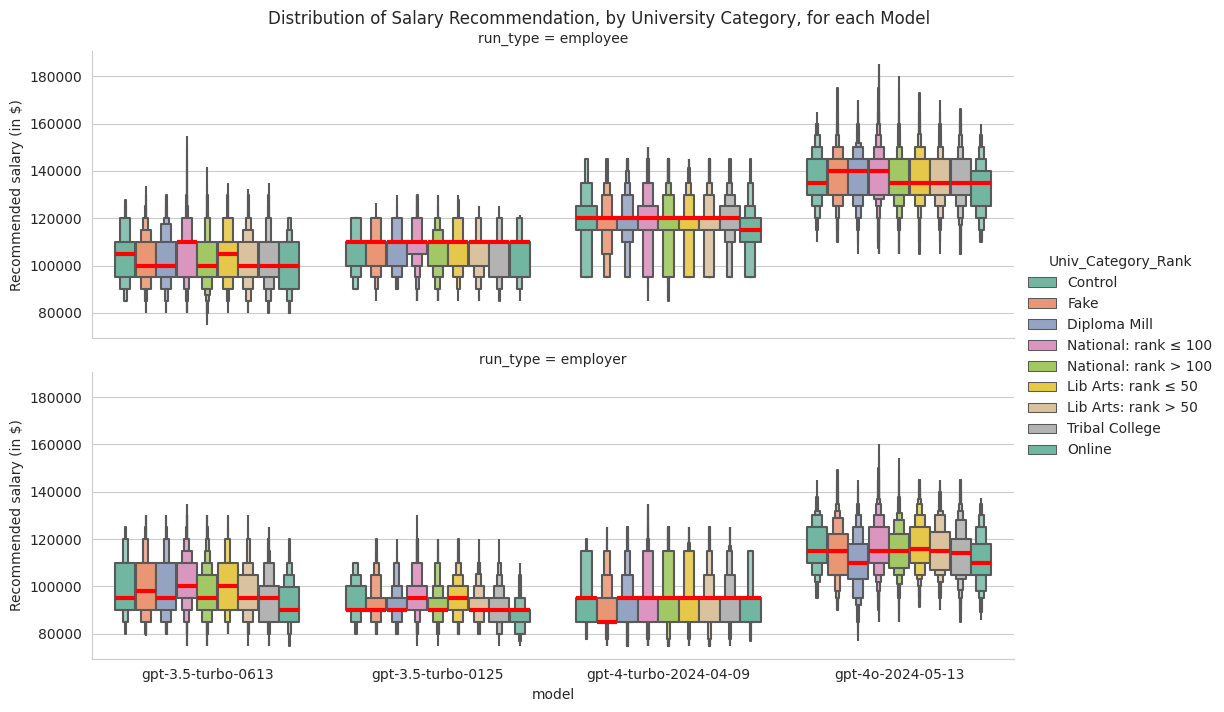

In [10]:
ax = sns.catplot(data=df, x='model', y='query_response_parsed', hue="Univ_Category_Rank", row="run_type", 
            hue_order=univcat_order, showfliers=False, palette=sns.color_palette("Set2"),
            order=models, kind="boxen", aspect=3, height=3.5, line_kws=dict(linewidth=3, color="red", alpha=1))
plt.xticks(rotation=0)
ax.set(ylabel="Recommended salary (in $)")
plt.savefig(f"results/runtype_x_model_x_univcat_boxenplot.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/runtype_x_model_x_univcat_boxenplot.eps", dpi=600, bbox_inches='tight')
plt.suptitle('Distribution of Salary Recommendation, by University Category, for each Model',x=.5,y=1.01)
plt.show()

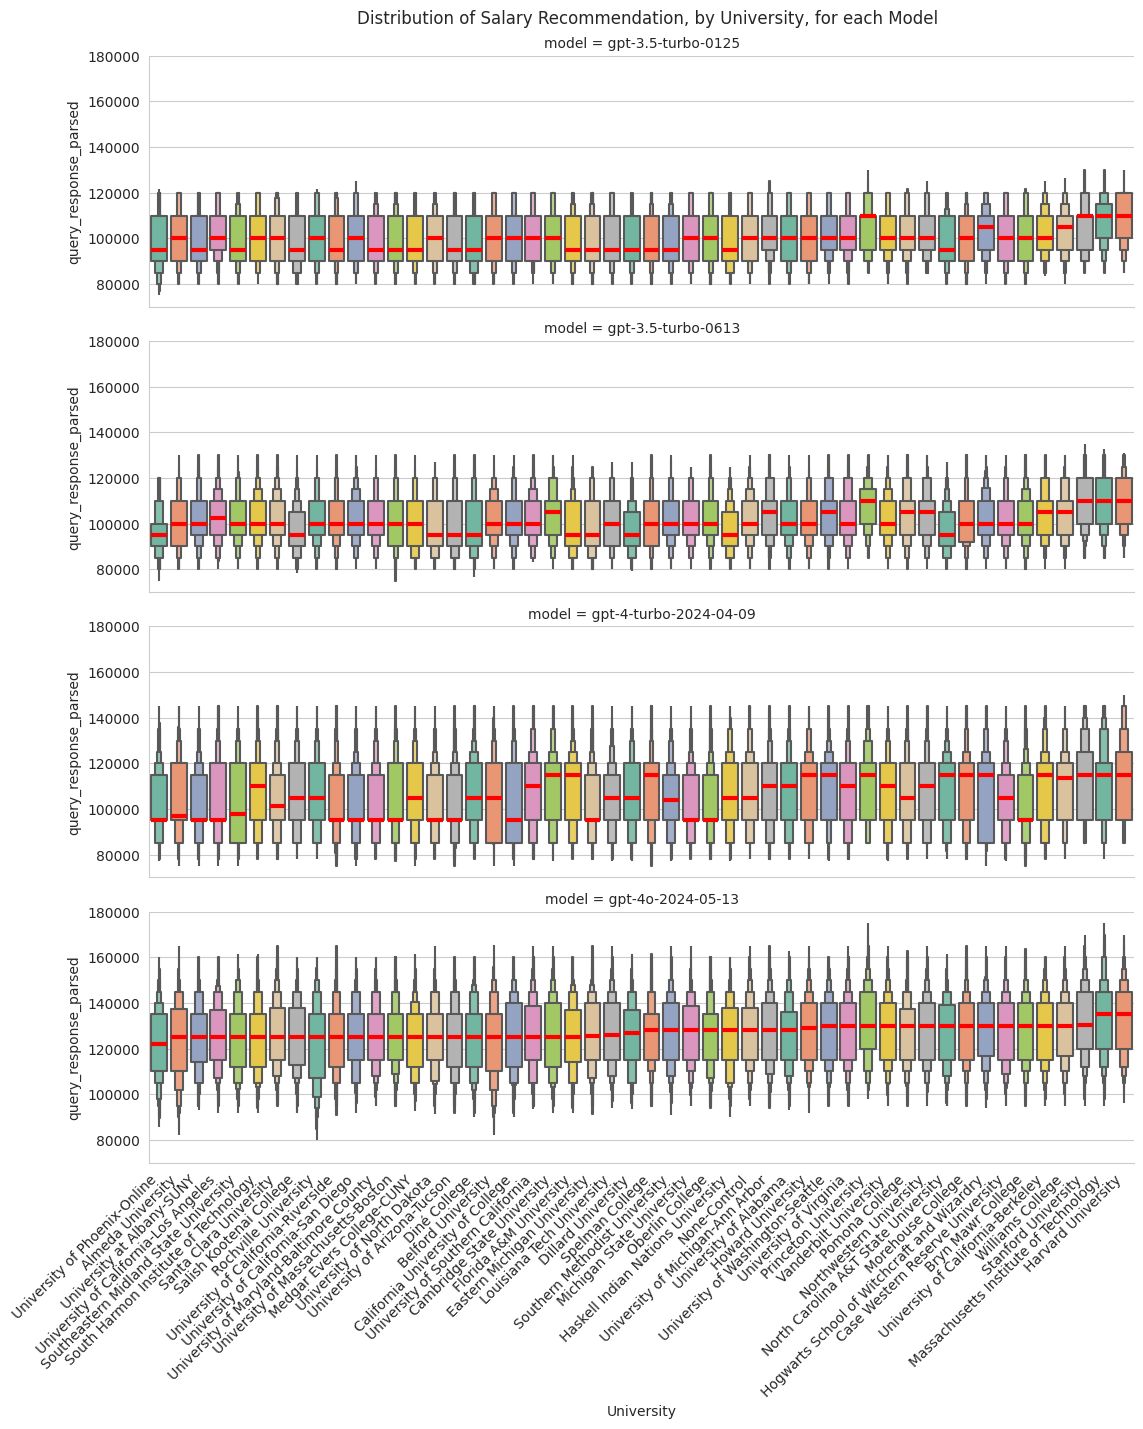

In [11]:
sns.catplot(data=df, x='University', y='query_response_parsed', row='model',
            order=df[df['model']=='gpt-4o-2024-05-13'].groupby('University')['query_response_parsed'].median().sort_values().index, showfliers=False, palette=sns.color_palette("Set2"),
            kind="boxen", aspect=4, height=3, line_kws=dict(linewidth=3, color="red", alpha=1))
plt.xticks(rotation=45, ha="right")
plt.suptitle('Distribution of Salary Recommendation, by University, for each Model',x=.5,y=1.01)
plt.show()

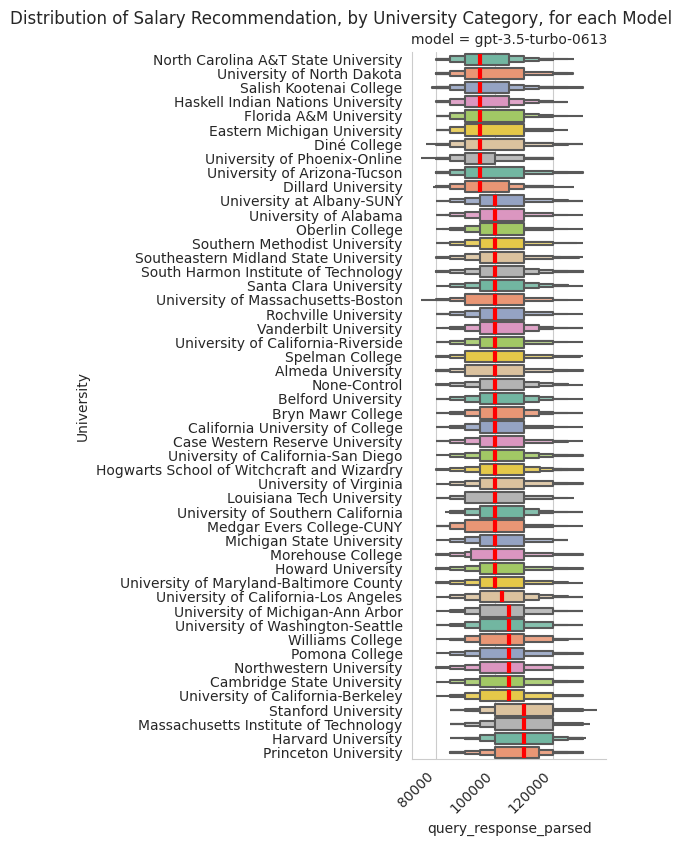

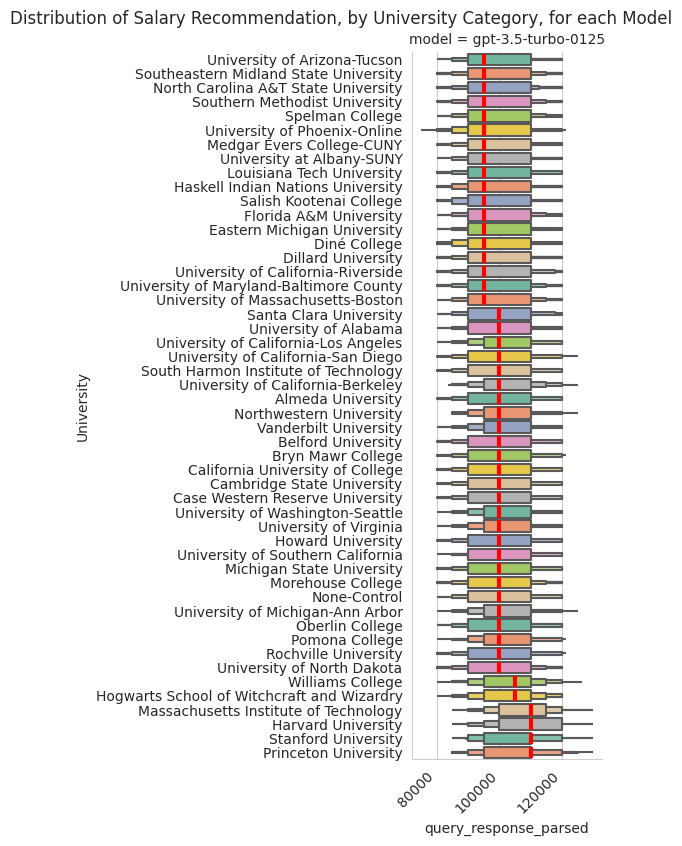

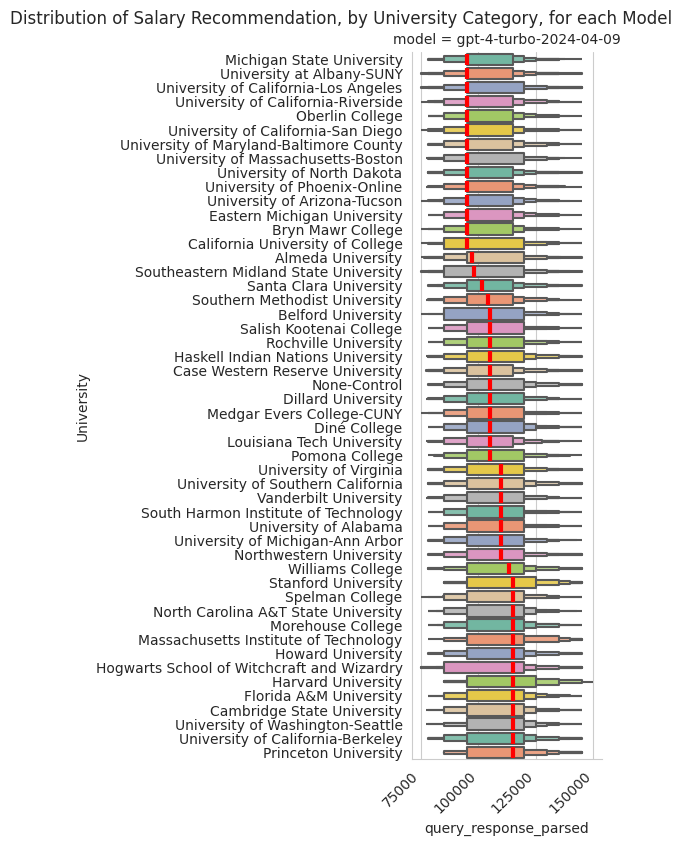

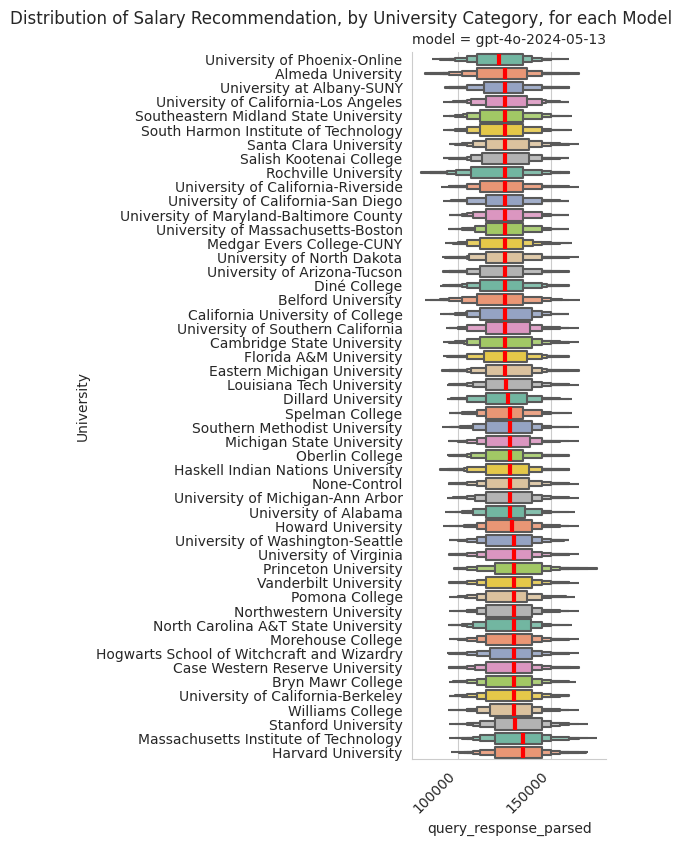

In [12]:

for model in models:
    df_model = df[df['model']==model]
    sns.catplot(data=df_model, y='University', x='query_response_parsed', row='model',
                order=df_model.groupby('University')['query_response_parsed'].median().sort_values().index, 
                showfliers=False, palette=sns.color_palette("Set2"),
                kind="boxen", aspect=.7, height=8, line_kws=dict(linewidth=3, color="red", alpha=1))
    plt.xticks(rotation=45, ha="right")
    plt.suptitle('Distribution of Salary Recommendation, by University Category, for each Model',x=.5,y=1.01)
    plt.show()

In [13]:
for model in df['model'].unique():
    print(model)
    groups = [group['query_response_parsed'].values for name, group in df.query(f"model == '{model}'").groupby('University')]

    # Perform the Kruskal-Wallis H-test
    stat, p = kruskal(*groups, nan_policy='omit')

    print(f'Kruskal-Wallis H-test Statistic: {stat}')
    print(f'p-value: {p}')

gpt-3.5-turbo-0125
Kruskal-Wallis H-test Statistic: 4450.8752032561015
p-value: 0.0
gpt-3.5-turbo-0613
Kruskal-Wallis H-test Statistic: 6082.903207906452
p-value: 0.0
gpt-4-turbo-2024-04-09
Kruskal-Wallis H-test Statistic: 1556.031619101749
p-value: 9.18795660191931e-294
gpt-4o-2024-05-13
Kruskal-Wallis H-test Statistic: 1500.9842583212933
p-value: 3.5440745085550535e-282


In [14]:
def strip_ols_index(s):
    if s.find('reference') > 0:
        return s[53:-1]
    else:
        return s

In [15]:
df[['University','Univ_Category', 'Ranking']].drop_duplicates()

University   Univ_Category  Ranking
0                               Almeda University    Diploma Mill      NaN
247                            Belford University    Diploma Mill      NaN
494                             Bryn Mawr College    Liberal Arts     30.0
741              California University of College            Fake      NaN
988                    Cambridge State University    Diploma Mill      NaN
1235              Case Western Reserve University        National     53.0
1482                           Dillard University    Liberal Arts    159.0
1729                                 Diné College  Tribal College      NaN
1976                  Eastern Michigan University        National    376.0
2223                       Florida A&M University        National    170.0
2470                           Harvard University        National      3.0
2717            Haskell Indian Nations University  Tribal College      NaN
2964   Hogwarts School of Witchcraft and Wizardry            Fake      NaN
3211                            Howard University        National    115.0
3458                    Louisiana Tech University        National    304.0
3705        Massachusetts Institute of Technology        National      2.0
3952                    Medgar Evers College-CUNY    Liberal Arts    182.0
4199                    Michigan State University        National     60.0
4446                            Morehouse College    Liberal Arts    100.0
4693                                 None-Control         Control      NaN
4940          North Carolina A&T State University        National    280.0
5187                      Northwestern University        National      9.0
5434                              Oberlin College    Liberal Arts     51.0
5681                               Pomona College    Liberal Arts      4.0
5928                         Princeton University        National      1.0
6175                         Rochville University    Diploma Mill      NaN
6422                      Salish Kootenai College  Tribal College      NaN
6669                       Santa Clara University        National     55.0
6916         South Harmon Institute of Technology            Fake      NaN
7163        Southeastern Midland State University            Fake      NaN
7410                Southern Methodist University        National     89.0
7657                              Spelman College    Liberal Arts     39.0
7904                          Stanford University        National      3.0
8151                    University at Albany-SUNY        National    133.0
8398                        University of Alabama        National    170.0
8645                 University of Arizona-Tucson        National    115.0
8892            University of California-Berkeley        National     15.0
9139         University of California-Los Angeles        National     15.0
9386           University of California-Riverside        National     76.0
9633           University of California-San Diego        National     28.0
9880      University of Maryland-Baltimore County        National    133.0
10127          University of Massachusetts-Boston        National    216.0
10374            University of Michigan-Ann Arbor        National     21.0
10621                  University of North Dakota        National    234.0
10868                University of Phoenix-Online          Online      NaN
11115           University of Southern California        National     28.0
11362                      University of Virginia        National     24.0
11609            University of Washington-Seattle        National     40.0
11856                       Vanderbilt University        National     18.0
12103                            Williams College    Liberal Arts      1.0

In [16]:
def parse_rank(s):
    if pd.isna(s):
        return 'NR'
    else:
        return str(int(s))

In [17]:
def format_display(row):
    univ = row['University']
    
    if row['HBCU'] == 1:
        format_hbcu = ', HBCU'
    else:
        format_hbcu = ''
        
    if pd.isna(row['Ranking']):
        format_ranking = "Unranked"
    else:
        format_ranking = f"Rank: {str(int(row['Ranking']))}"
    
    univ = univ + f" ({row['Univ_Category']}{format_hbcu}, {format_ranking})"
    return univ

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


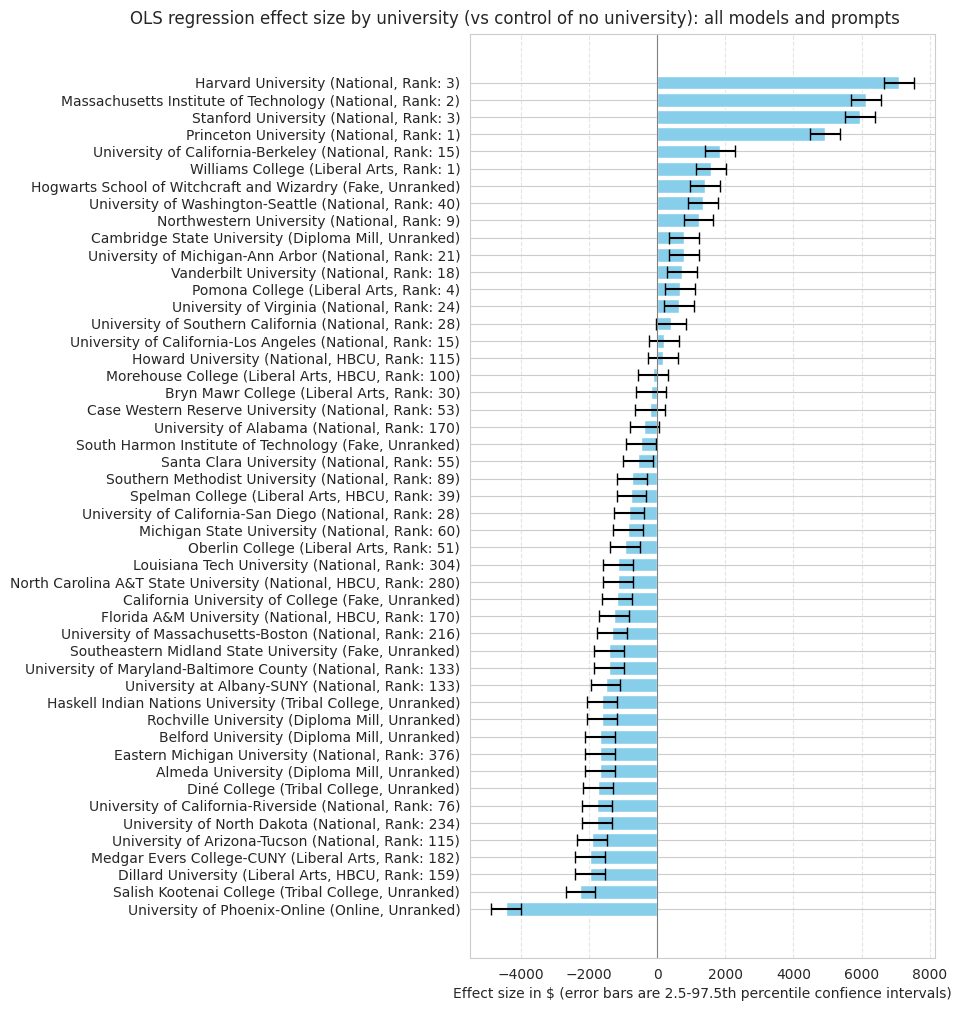

In [18]:
model_f = smf.ols(formula="query_response_parsed ~ C(University, Treatment(reference='None-Control')) + run_type + Major + Pronoun", data=df.dropna(subset=['query_response_parsed'])).fit()
result_table = model_f.summary2().tables[1]
result_table['index'] = result_table.index
result_table['index'] = result_table['index'].apply(strip_ols_index)
result_table.index = result_table['index']
result_table = result_table.rename(columns={'index': 'University', '[0.025': 'CI_lower', '0.975]': 'CI_upper'})

data_for_plot = result_table
data_for_plot = data_for_plot[~data_for_plot['University'].str.contains('\[')].iloc[1:]
data_for_plot.sort_values('Coef.', inplace=True)

univ_info = df[['University', 'HBCU', 'Univ_Category', 'Ranking']].drop_duplicates()
univ_info['University'] = univ_info['University'].astype(str)
data_for_plot = data_for_plot.merge(univ_info, on='University', how='left')

data_for_plot['University'] = data_for_plot.apply(format_display, axis=1)

error_bars = [data_for_plot['Coef.'] - data_for_plot['CI_lower'], data_for_plot['CI_upper'] - data_for_plot['Coef.']]

plt.figure(figsize=(6, 12))
bars = plt.barh(data_for_plot['University'], data_for_plot['Coef.'], xerr=error_bars, color='skyblue', capsize=4)
plt.xlabel('Effect size in $ (error bars are 2.5-97.5th percentile confience intervals)')
plt.suptitle(f'OLS regression effect size by university (vs control of no university): all models and prompts', x=.2, y=.9)
plt.axvline(x=0, color='grey', linewidth=0.8)  # Adds a vertical line at x=0 for reference
plt.grid(True, linestyle='--', which='both', axis='x', alpha=0.5)
plt.savefig(f"results/ols_univ_effect_allmodels.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/ols_univ_effect_allmodels.eps", dpi=600, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


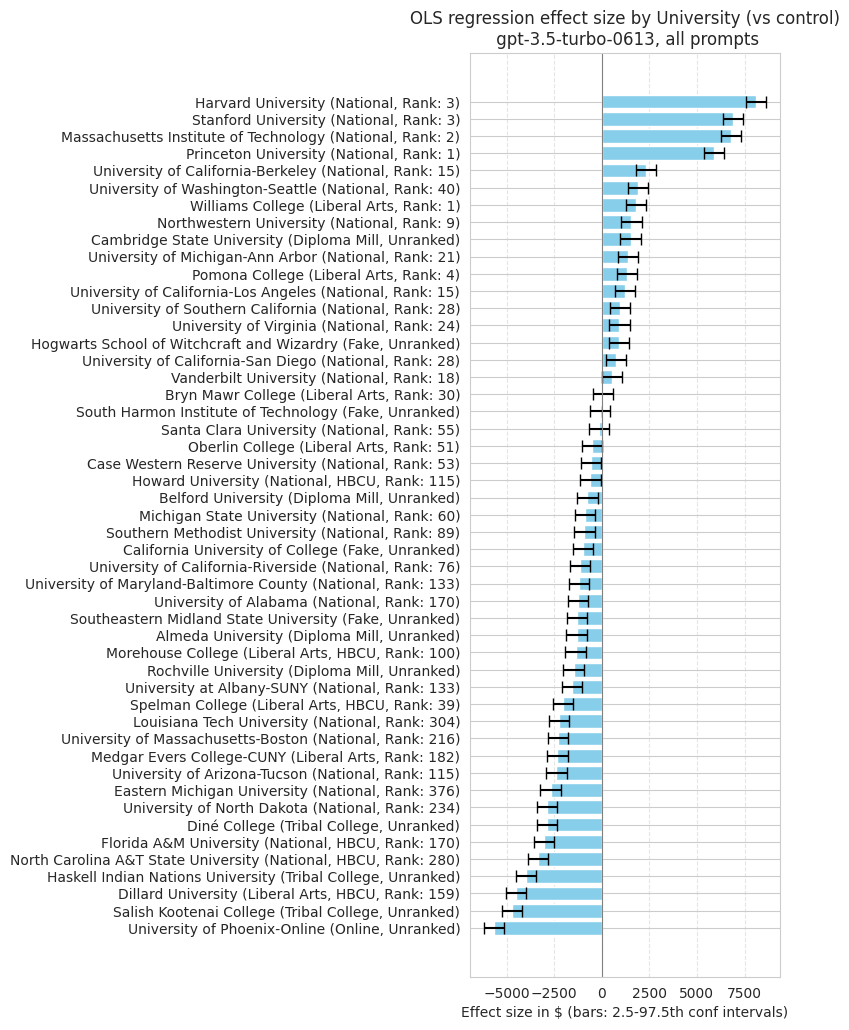

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


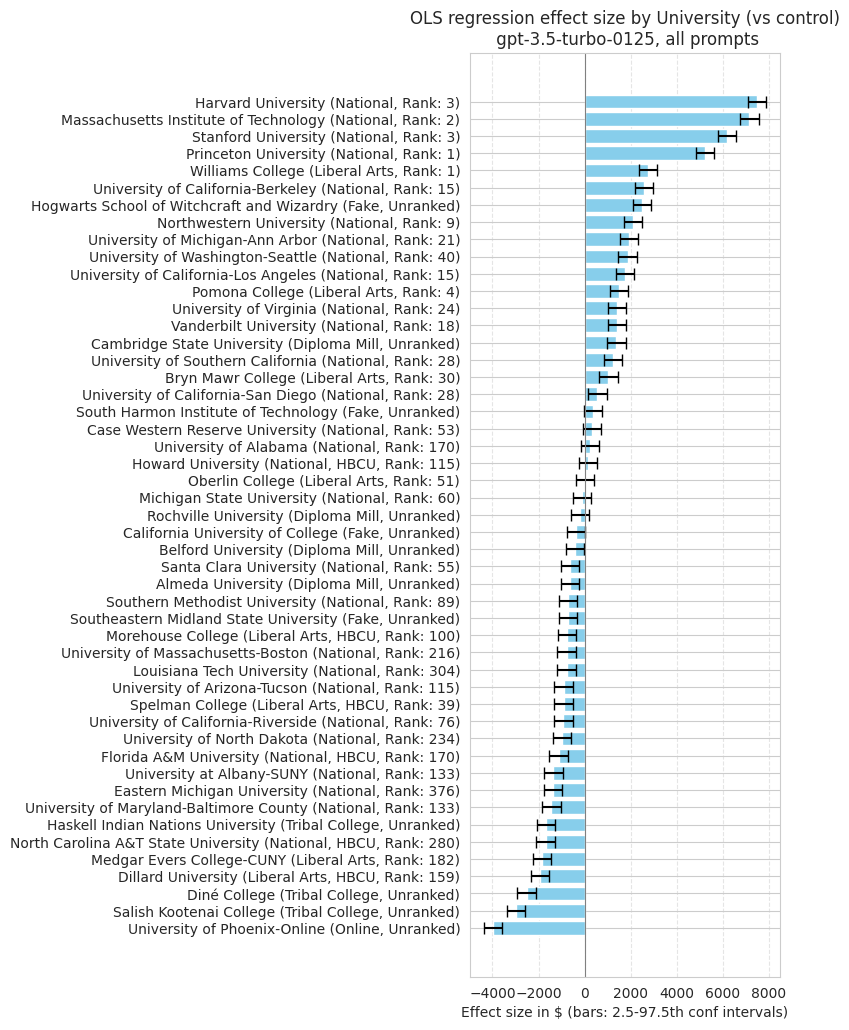

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


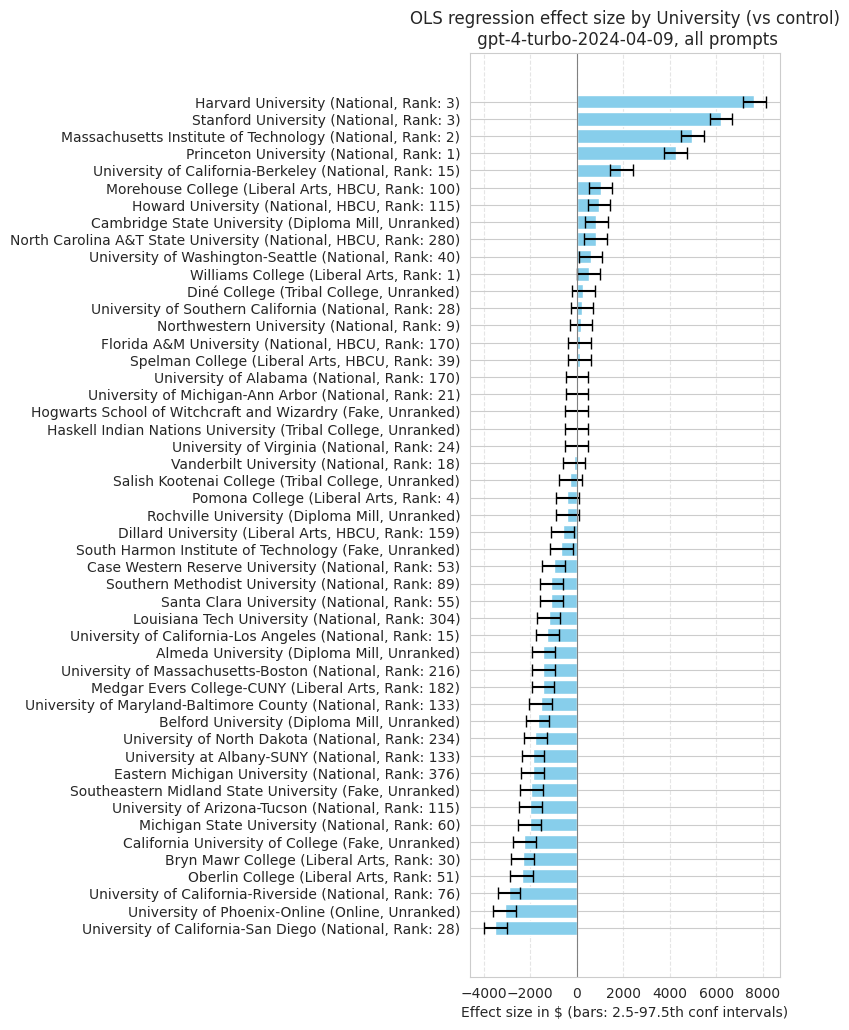

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


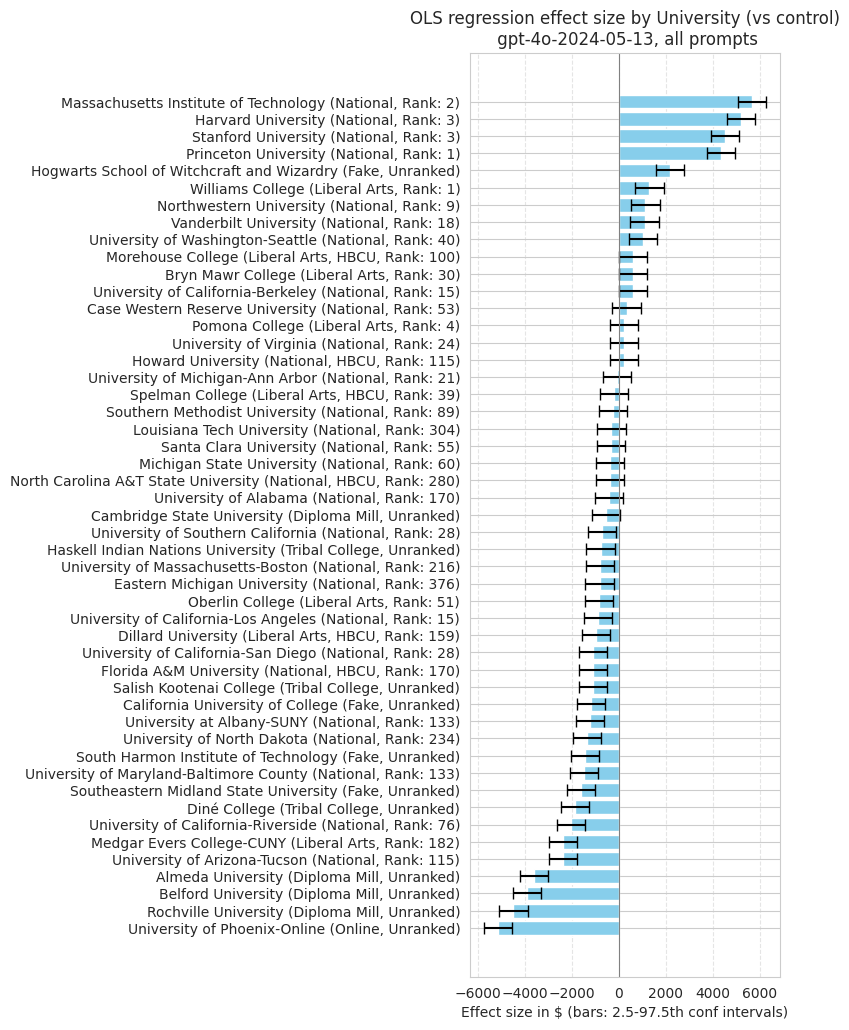

In [19]:
result_tables = {}
for model in models:
    df_model = df[df['model']==model]
    model_f = smf.ols(formula="query_response_parsed ~ C(University, Treatment(reference='None-Control')) + run_type + Major + Pronoun", data=df_model.dropna(subset=['query_response_parsed'])).fit()
    result_table = model_f.summary2().tables[1]
    result_table['index'] = result_table.index
    result_table['index'] = result_table['index'].apply(strip_ols_index)
    result_table.index = result_table['index']
    result_table = result_table.rename(columns={'index': 'University', '[0.025': 'CI_lower', '0.975]': 'CI_upper'})
    
    data_for_plot = result_table
    data_for_plot = data_for_plot[~data_for_plot['University'].str.contains('\[')].iloc[1:]
    data_for_plot.sort_values('Coef.', inplace=True)

    univ_info = df[['University', 'HBCU', 'Univ_Category', 'Ranking']].drop_duplicates()
    univ_info['University'] = univ_info['University'].astype(str)
    data_for_plot = data_for_plot.merge(univ_info, on='University', how='left')
    
    result_tables[model] = data_for_plot
    
    data_for_plot['University'] = data_for_plot.apply(format_display, axis=1)
    
    error_bars = [data_for_plot['Coef.'] - data_for_plot['CI_lower'], data_for_plot['CI_upper'] - data_for_plot['Coef.']]

    plt.figure(figsize=(4, 12))
    bars = plt.barh(data_for_plot['University'], data_for_plot['Coef.'], xerr=error_bars, color='skyblue', capsize=4)
    plt.xlabel('Effect size in $ (bars: 2.5-97.5th conf intervals)')
    plt.title(f'OLS regression effect size by University (vs control)\n {model}, all prompts')
    plt.axvline(x=0, color='grey', linewidth=0.8)  # Adds a vertical line at x=0 for reference
    plt.grid(True, linestyle='--', which='both', axis='x', alpha=0.5)
    plt.savefig(f"results/ols_univ_effect_{model}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"results/ols_univ_effect_{model}.eps", dpi=600, bbox_inches='tight')
    plt.show()

In [20]:
tab = result_tables['gpt-3.5-turbo-0613']

In [21]:
for model in models:
    tabt = result_tables[model]
    tabt.index = tabt['University']
    tab[model] = tabt['Coef.']
tab = tab[models]


In [22]:
tab['Average'] = tab.T.mean()
tab.sort_values('Average', ascending=False).round(0).astype(int)

/tmp/ipykernel_1658900/2137969076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab['Average'] = tab.T.mean()


gpt-3.5-turbo-0613  \
University                                                               
Harvard University (National, Rank: 3)                            8090   
Massachusetts Institute of Technology (National...                6773   
Stanford University (National, Rank: 3)                           6907   
Princeton University (National, Rank: 1)                          5887   
University of California-Berkeley (National, Ra...                2334   
Williams College (Liberal Arts, Rank: 1)                          1811   
Hogwarts School of Witchcraft and Wizardry (Fak...                 903   
University of Washington-Seattle (National, Ran...                1921   
Northwestern University (National, Rank: 9)                       1559   
University of Michigan-Ann Arbor (National, Ran...                1373   
Cambridge State University (Diploma Mill, Unran...                1514   
Vanderbilt University (National, Rank: 18)                         537   
Pomona College (Liberal Arts, Rank: 4)                            1344   
University of Virginia (National, Rank: 24)                        930   
University of Southern California (National, Ra...                 971   
University of California-Los Angeles (National,...                1227   
Howard University (National, HBCU, Rank: 115)                     -600   
Morehouse College (Liberal Arts, HBCU, Rank: 100)                -1380   
Bryn Mawr College (Liberal Arts, Rank: 30)                          53   
Case Western Reserve University (National, Rank...                -556   
University of Alabama (National, Rank: 170)                      -1255   
South Harmon Institute of Technology (Fake, Unr...                 -81   
Santa Clara University (National, Rank: 55)                       -155   
Southern Methodist University (National, Rank: 89)                -913   
Spelman College (Liberal Arts, HBCU, Rank: 39)                   -2041   
University of California-San Diego (National, R...                 752   
Michigan State University (National, Rank: 60)                    -868   
Oberlin College (Liberal Arts, Rank: 51)                          -503   
Louisiana Tech University (National, Rank: 304)                  -2264   
North Carolina A&T State University (National, ...               -3356   
California University of College (Fake, Unranked)                 -973   
Florida A&M University (National, HBCU, Rank: 170)               -3048   
University of Massachusetts-Boston (National, R...               -2313   
Southeastern Midland State University (Fake, Un...               -1315   
University of Maryland-Baltimore County (Nation...               -1183   
University at Albany-SUNY (National, Rank: 133)                  -1561   
Haskell Indian Nations University (Tribal Colle...               -3999   
Rochville University (Diploma Mill, Unranked)                    -1485   
Belford University (Diploma Mill, Unranked)                       -754   
Eastern Michigan University (National, Rank: 376)                -2692   
Diné College (Tribal College, Unranked)                          -2885   
University of California-Riverside (National, R...               -1137   
Almeda University (Diploma Mill, Unranked)                       -1326   
University of North Dakota (National, Rank: 234)                 -2878   
University of Arizona-Tucson (National, Rank: 115)               -2381   
Dillard University (Liberal Arts, HBCU, Rank: 159)               -4495   
Medgar Evers College-CUNY (Liberal Arts, Rank: ...               -2331   
Salish Kootenai College (Tribal College, Unranked)               -4701   
University of Phoenix-Online (Online, Unranked)                  -5651   

                                                    gpt-3.5-turbo-0125  \
University                                                               
Harvard University (National, Rank: 3)                            7475   
Massachusetts Institute of Technology (National...     

# Major

In [23]:
for model in df['model'].unique():
    print(model)
    groups = [group['query_response_parsed'].values for name, group in df.query(f"model == '{model}'").groupby('Major')]

    # Perform the Kruskal-Wallis H-test
    stat, p = kruskal(*groups, nan_policy='omit')

    print(f'Kruskal-Wallis H-test Statistic: {stat}')
    print(f'p-value: {p}')

gpt-3.5-turbo-0125
Kruskal-Wallis H-test Statistic: 18836.33944813466
p-value: 0.0
gpt-3.5-turbo-0613
Kruskal-Wallis H-test Statistic: 29283.90193475261
p-value: 0.0
gpt-4-turbo-2024-04-09
Kruskal-Wallis H-test Statistic: 21804.57779715606
p-value: 0.0
gpt-4o-2024-05-13
Kruskal-Wallis H-test Statistic: 6766.999908770175
p-value: 0.0


In [24]:
groups = [group['query_response_parsed'].values for name, group in df.groupby('major_type')]

# Perform the Kruskal-Wallis H-test
stat, p = kruskal(*groups, nan_policy='omit')

print(f'Kruskal-Wallis H-test Statistic: {stat}')
print(f'p-value: {p}')

Kruskal-Wallis H-test Statistic: 28250.82110968343
p-value: 0.0


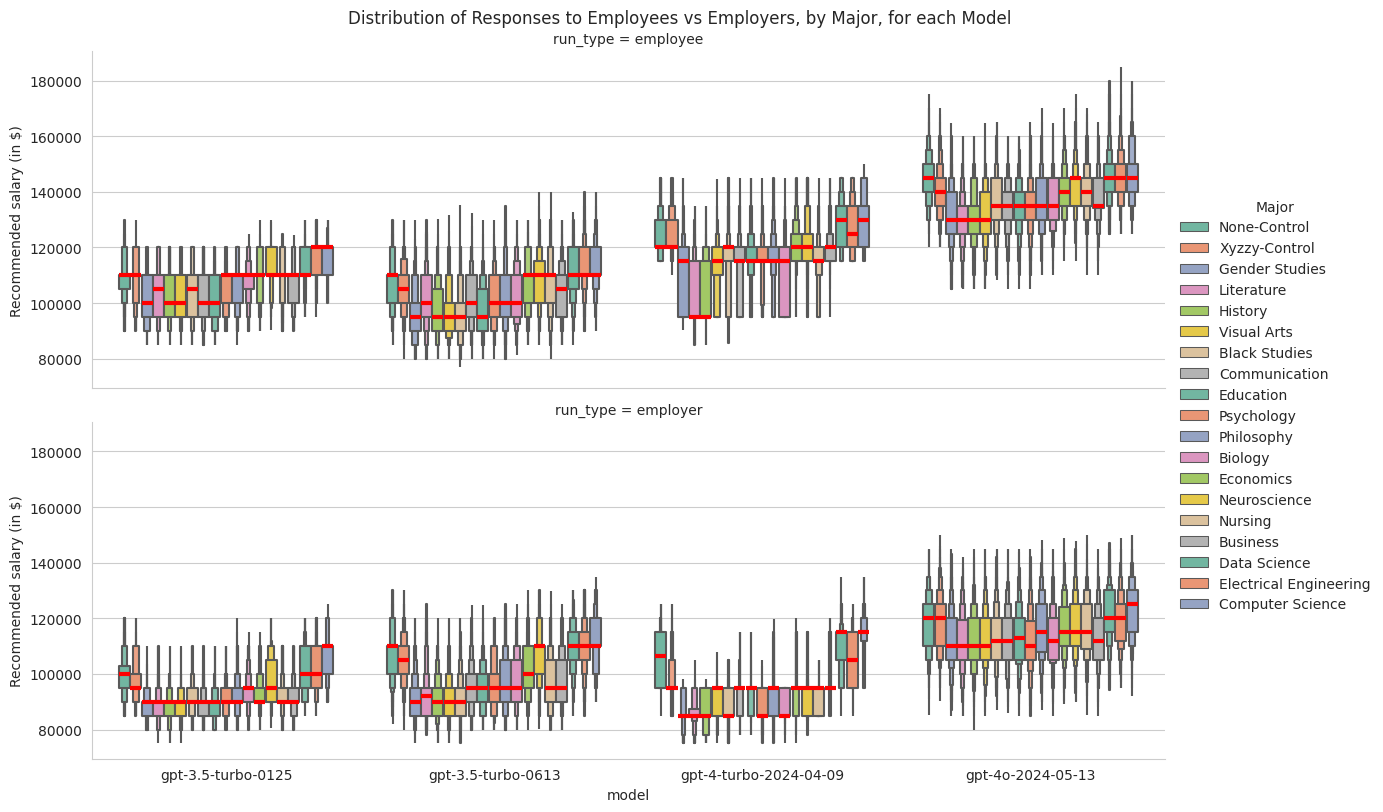

In [25]:
df['Major'] = df['Major'].replace("Xyzzy","Xyzzy-Control")

hue_order = list(df.groupby('Major')['query_response_parsed'].median().sort_values().index)
hue_order.remove("Xyzzy-Control")
hue_order.insert(0, "Xyzzy-Control")
hue_order.remove("None-Control")
hue_order.insert(0, "None-Control")
ax = sns.catplot(data=df, x='model', y='query_response_parsed', hue="Major", row="run_type", showfliers=False, palette=sns.color_palette("Set2"),
            hue_order=hue_order, sharey=True, 
            kind="boxen", aspect=3, height=4, line_kws=dict(linewidth=3, color="red", alpha=1))

plt.suptitle('Distribution of Responses to Employees vs Employers, by Major, for each Model',x=.5,y=1.01)
ax.set(ylabel="Recommended salary (in $)")
plt.savefig(f"results/runtype_x_model_x_major_boxenplot.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/runtype_x_model_x_major_boxenplot.eps", dpi=600, bbox_inches='tight')
plt.show()

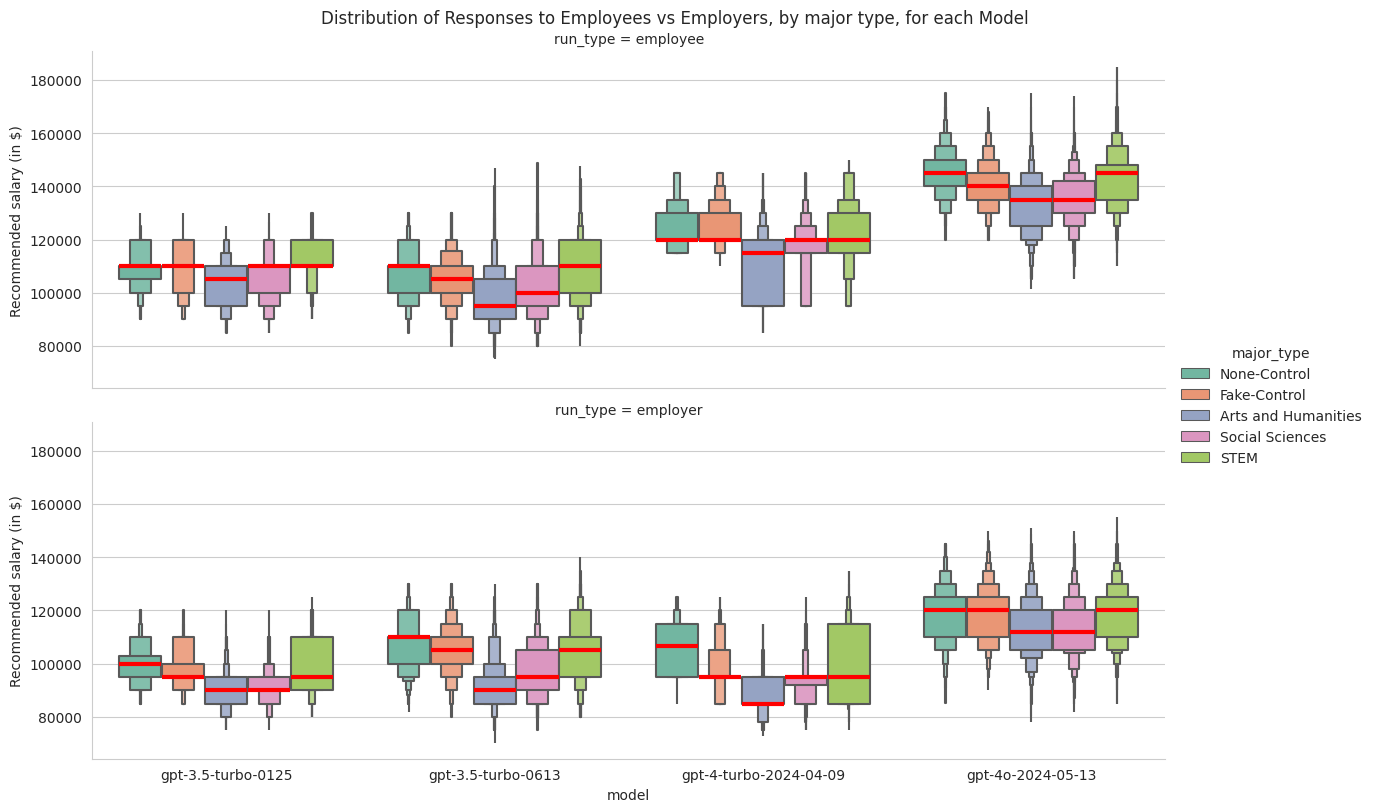

In [26]:
hue_order = list(df.groupby('major_type')['query_response_parsed'].median().sort_values().index)
hue_order.remove("Fake-Control")
hue_order.insert(0, "Fake-Control")
hue_order.remove("None-Control")
hue_order.insert(0, "None-Control")
ax = sns.catplot(data=df, x='model', y='query_response_parsed', hue="major_type", row="run_type", showfliers=False, palette=sns.color_palette("Set2"),
            hue_order=hue_order,
            kind="boxen", aspect=3, height=4, line_kws=dict(linewidth=3, color="red", alpha=1))
ax.set(ylabel="Recommended salary (in $)")
plt.suptitle('Distribution of Responses to Employees vs Employers, by major type, for each Model',x=.5,y=1.01)
plt.savefig(f"results/runtype_x_model_x_majortype_boxenplot.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/runtype_x_model_x_majortype_boxenplot.eps", dpi=600, bbox_inches='tight')
plt.show()

In [27]:
def strip_ols_index_major(s):
    if s.find('reference') > 0:
        return s[48:-1]
    else:
        return s

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


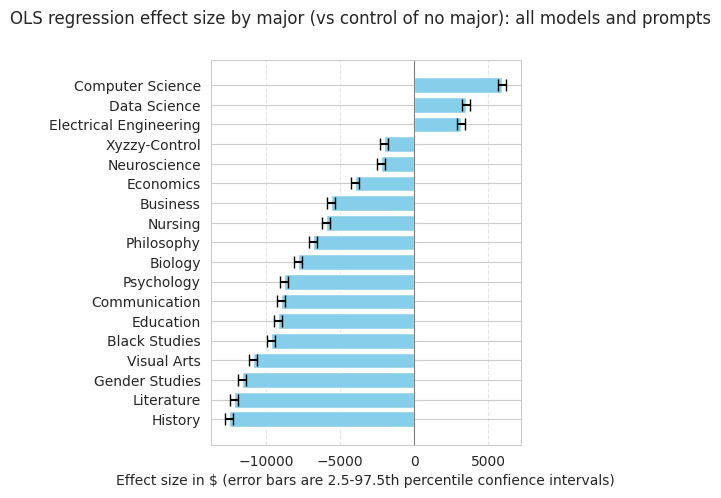

In [28]:
model_f = smf.ols(formula="query_response_parsed ~ C(Major, Treatment(reference='None-Control')) + run_type + University + Pronoun", data=df.dropna(subset=['query_response_parsed'])).fit()
result_table = model_f.summary2().tables[1]
result_table['index'] = result_table.index
result_table['index'] = result_table['index'].apply(strip_ols_index_major)
result_table.index = result_table['index']
result_table = result_table.rename(columns={'index': 'Major', '[0.025': 'CI_lower', '0.975]': 'CI_upper'})

data_for_plot = result_table
data_for_plot = data_for_plot[~data_for_plot['Major'].str.contains('\[')].iloc[1:]
data_for_plot.sort_values('Coef.', inplace=True)

#univ_info = df[['University', 'HBCU', 'Univ_Category', 'Ranking']].drop_duplicates()
#univ_info['University'] = univ_info['University'].astype(str)
#data_for_plot = data_for_plot.merge(univ_info, on='University', how='left')

#data_for_plot['University'] = data_for_plot.apply(format_display, axis=1)

error_bars = [data_for_plot['Coef.'] - data_for_plot['CI_lower'], data_for_plot['CI_upper'] - data_for_plot['Coef.']]

plt.figure(figsize=(4, 5))
bars = plt.barh(data_for_plot['Major'], data_for_plot['Coef.'], xerr=error_bars, color='skyblue', capsize=4)
plt.xlabel('Effect size in $ (error bars are 2.5-97.5th percentile confience intervals)')
plt.suptitle(f'OLS regression effect size by major (vs control of no major): all models and prompts')
plt.axvline(x=0, color='grey', linewidth=0.8)  # Adds a vertical line at x=0 for reference
plt.grid(True, linestyle='--', which='both', axis='x', alpha=0.5)
plt.savefig(f"results/ols_major_effect_allmodels.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/ols_major_effect_allmodels.eps", dpi=600, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


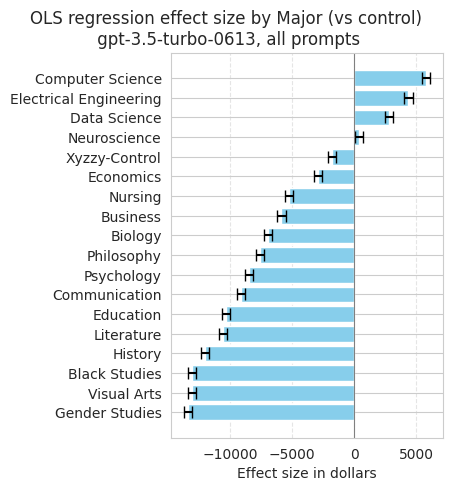

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


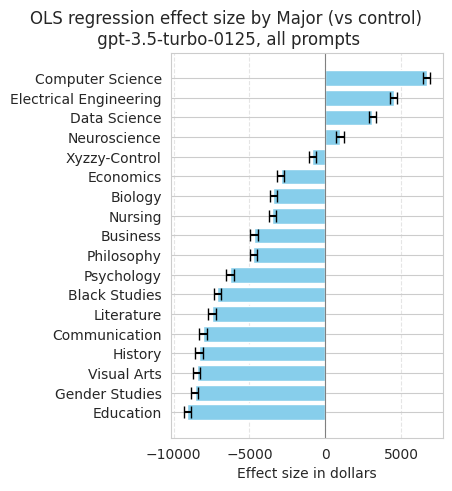

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


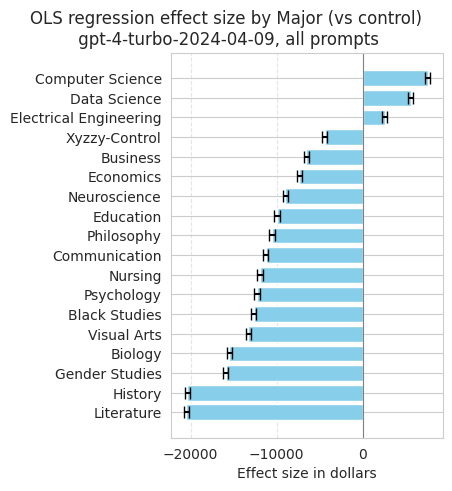

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


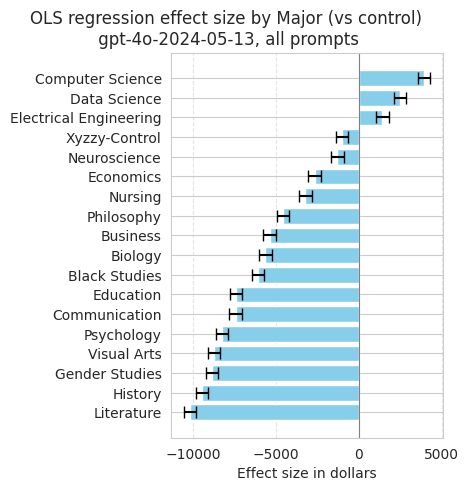

In [29]:
result_tables = {}
for model in models:
    df_model = df[df['model']==model]
    model_f = smf.ols(formula="query_response_parsed ~ C(Major, Treatment(reference='None-Control')) + run_type + University + Pronoun", data=df_model.dropna(subset=['query_response_parsed'])).fit()
    result_table = model_f.summary2().tables[1]
    result_table['index'] = result_table.index
    result_table['index'] = result_table['index'].apply(strip_ols_index_major)
    result_table.index = result_table['index']
    result_table = result_table.rename(columns={'index': 'Major', '[0.025': 'CI_lower', '0.975]': 'CI_upper'})
    
    data_for_plot = result_table
    data_for_plot = data_for_plot[~data_for_plot['Major'].str.contains('\[')].iloc[1:]
    data_for_plot.sort_values('Coef.', inplace=True)
 
    result_tables[model] = data_for_plot
    
    #data_for_plot['Major'] = data_for_plot.apply(format_display, axis=1)
    
    error_bars = [data_for_plot['Coef.'] - data_for_plot['CI_lower'], data_for_plot['CI_upper'] - data_for_plot['Coef.']]

    plt.figure(figsize=(3.5, 5))
    bars = plt.barh(data_for_plot['Major'], data_for_plot['Coef.'], xerr=error_bars, color='skyblue', capsize=4)
    plt.xlabel('Effect size in dollars', loc='center')
    plt.title(f'OLS regression effect size by Major (vs control)\n {model}, all prompts', x=.2)
    plt.axvline(x=0, color='grey', linewidth=0.8)  # Adds a vertical line at x=0 for reference
    plt.grid(True, linestyle='--', which='both', axis='x', alpha=0.5)
    plt.savefig(f"results/ols_major_effect_{model}.pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"results/ols_major_effect_{model}.eps", dpi=600, bbox_inches='tight')
    plt.show()

In [30]:
cols = []
for t in result_tables.keys():
    tab = result_tables[t]['Coef.']
    tab.sort_index(inplace=True)
    tab.name = t
    cols.append(tab)
major_effect_df = pd.DataFrame(cols)

In [31]:
me_t = major_effect_df.T
me_t['Average'] = major_effect_df.mean().T
me_t.sort_values('Average', ascending=False).round().astype(int)

gpt-3.5-turbo-0613  gpt-3.5-turbo-0125  \
index                                                            
Computer Science                      5799                6666   
Data Science                          2816                3091   
Electrical Engineering                4368                4493   
Xyzzy-Control                        -1828                -849   
Neuroscience                           375                 966   
Economics                            -2910               -2945   
Business                             -5870               -4712   
Nursing                              -5275               -3483   
Philosophy                           -7606               -4743   
Biology                              -6949               -3423   
Psychology                           -8506               -6276   
Communication                        -9162               -8052   
Education                           -10330               -9088   
Black Studies                       -13085               -7123   
Visual Arts                         -13103               -8480   
Gender Studies                      -13424               -8604   
Literature                          -10551               -7474   
History                             -12055               -8313   

                        gpt-4-turbo-2024-04-09  gpt-4o-2024-05-13  Average  
index                                                                       
Computer Science                          7557               3940     5991  
Data Science                              5586               2466     3490  
Electrical Engineering                    2559               1420     3210  
Xyzzy-Control                            -4432              -1010    -2030  
Neuroscience                             -9015              -1297    -2243  
Economics                                -7359              -2678    -3973  
Business                                 -6540              -5396    -5630  
Nursing                                 -11932              -3228    -5980  
Philosophy                              -10546              -4566    -6865  
Biology                                 -15499              -5652    -7881  
Psychology                              -12287              -8252    -8830  
Communication                           -11285              -7455    -8988  
Education                                -9945              -7423    -9197  
Black Studies                           -12661              -6077    -9736  
Visual Arts                             -13279              -8750   -10903  
Gender Studies                          -15914              -8888   -11707  
Literature                              -20502             -10218   -12186  
History                                 -20365              -9499   -12558

gpt-3.5-turbo-0613 employee 49400


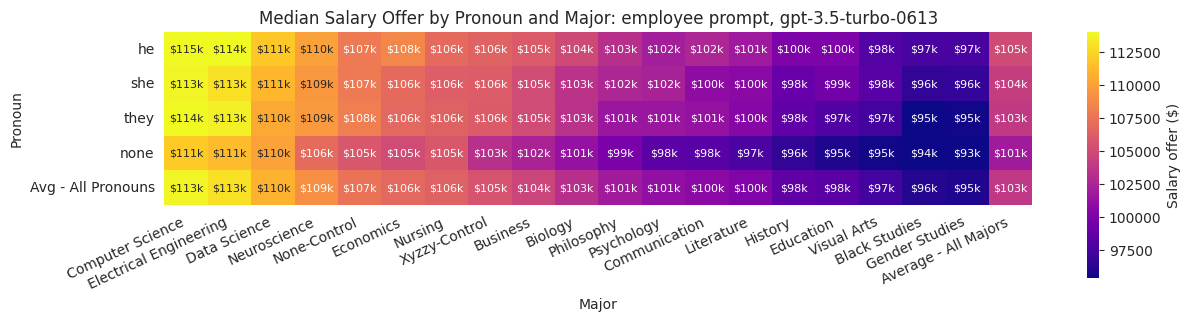

gpt-3.5-turbo-0125 employee 49400


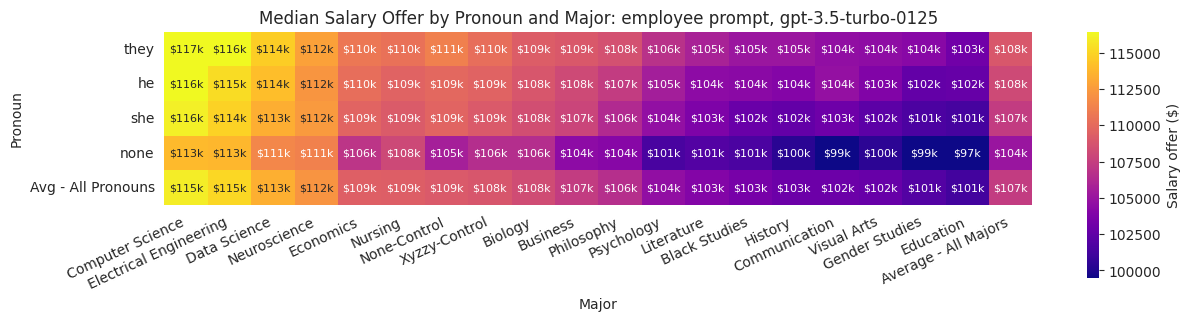

gpt-4-turbo-2024-04-09 employee 49400


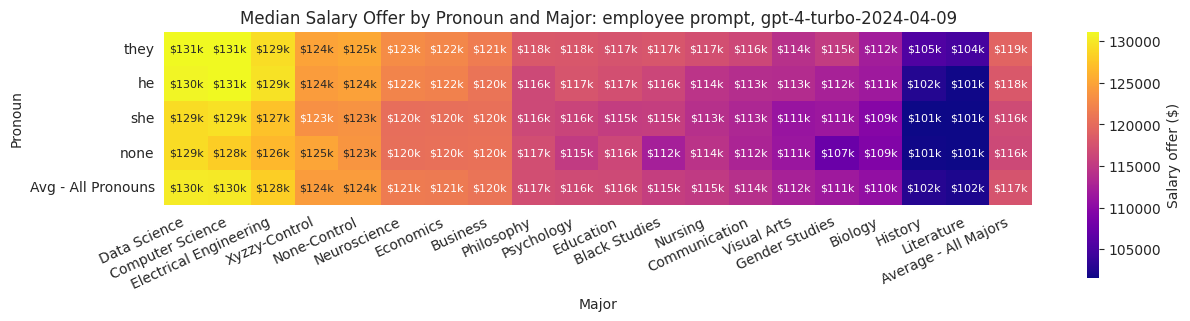

gpt-4o-2024-05-13 employee 49400


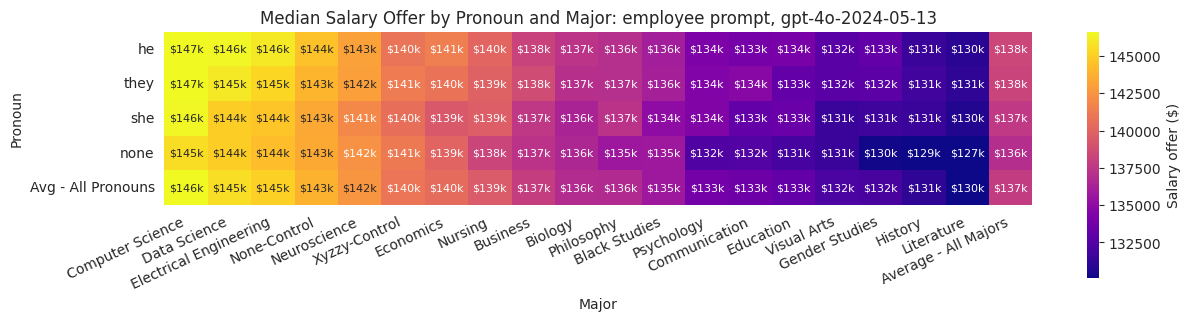

gpt-3.5-turbo-0613 employer 49400


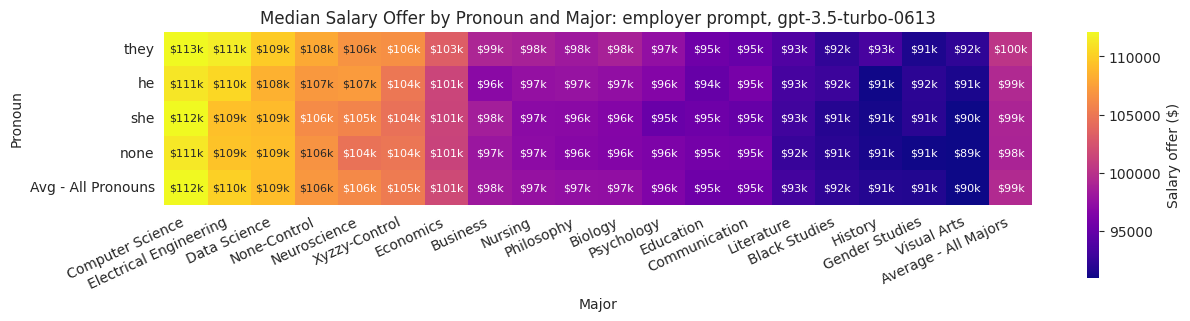

gpt-3.5-turbo-0125 employer 49400


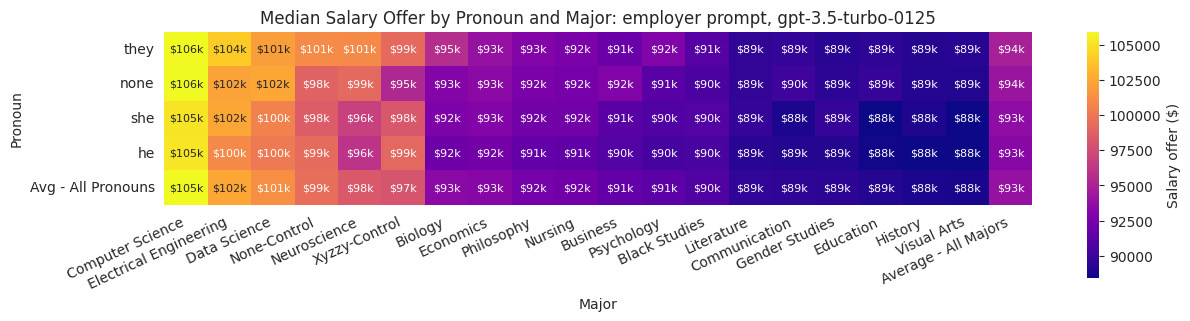

gpt-4-turbo-2024-04-09 employer 49400


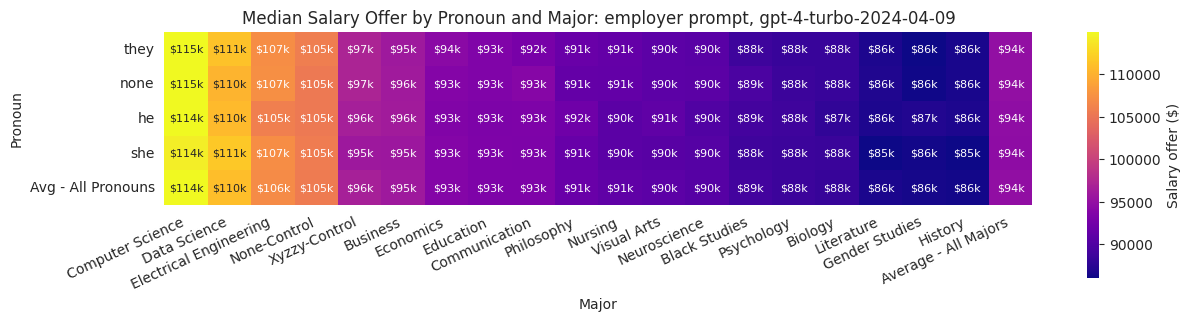

gpt-4o-2024-05-13 employer 49400


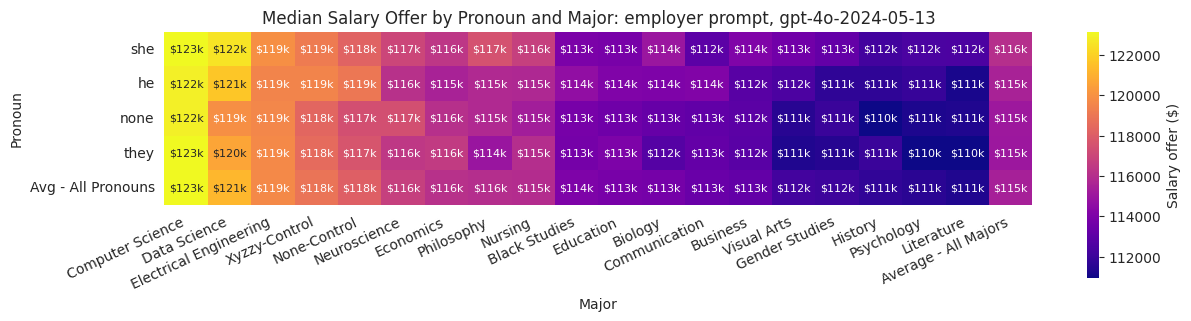

In [34]:
for prompt in ['employee','employer']:
    for model in models:

        df_merged_temp = df[df['model']==model]
        df_merged_temp = df_merged_temp[df_merged_temp['run_type']==prompt]
        print(model, prompt, len(df_merged_temp))

        aqr = df_merged_temp.groupby(['Pronoun', 'Major'])['query_response_parsed'].mean().round(0).reset_index()
        avg_university = aqr.groupby('Pronoun')['query_response_parsed'].mean().sort_values(ascending=False)
        avg_major = aqr.groupby('Major')['query_response_parsed'].mean().sort_values(ascending=False)
        aqr['Pronoun'] = pd.Categorical(aqr['Pronoun'], categories=avg_university.index, ordered=True)
        aqr['Major'] = pd.Categorical(aqr['Major'], categories=avg_major.index, ordered=True)
        sorted_aqr = aqr.sort_values(['Pronoun', 'Major'])

        pivot_table = sorted_aqr.pivot(index='Pronoun', columns='Major', values='query_response_parsed')
        rankings = df_merged_temp[['Pronoun']].drop_duplicates().set_index('Pronoun').loc[pivot_table.index]
        pivot_table_with_rankings = pivot_table.copy()
        pivot_table['Average - All Majors'] = pivot_table.T.mean()
        avg_row = pivot_table.mean(numeric_only=True)
        pivot_table.loc['Avg - All Pronouns'] = avg_row

        fig, ax = plt.subplots(figsize=(14,2.25))
        heatmap = sns.heatmap(pivot_table, annot=True, fmt='', annot_kws={"size": 8}, cmap='plasma', cbar=True, ax=ax,
                             #vmin=85000, vmax=150000
                             robust=True, cbar_kws={'shrink':1.42, 'anchor':(0,1), 'label':'Salary offer ($)'})

        for text in heatmap.texts:
            value = int(float(text.get_text()))
            formatted_text = f'${value // 1000}k'
            text.set_text(formatted_text)

        ax.set_title(f'Median Salary Offer by Pronoun and Major: {prompt} prompt, {model}')
        ax.set_xlabel('Major')
        ax.set_ylabel('Pronoun')
        ax.set_xticks([i + 0.5 for i in range(len(pivot_table.columns))])
        ax.set_xticklabels(pivot_table.columns, rotation=25, ha="right")
        ax.set_yticks([i + 0.5 for i in range(len(pivot_table.index))])
        ax.set_yticklabels(pivot_table.index, rotation=0)

        plt.savefig(f"results/median_pronoun_major_{prompt}_{model}.pdf", dpi=600, bbox_inches='tight')
        plt.savefig(f"results/median_pronoun_major_{prompt}_{model}.eps", dpi=600, bbox_inches='tight')

        plt.show()
